<a href="https://colab.research.google.com/github/fpgmina/gibbs/blob/main/gibbs_posterior_sharpe.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import invgamma
from typing import Tuple

### UTILS TO GENERATE RETURNS

In [22]:

def generate_normal_rets(
    n: int = 10_000,
    mean: float = 1.0,
    std: float = 1.0,
    seed: int = 42
) -> np.ndarray:
    """
    Generate 'n' samples from a normal (Gaussian) distribution.

    Parameters:
        n (int): Number of samples to generate.
        mean (float): Desired mean of the distribution.
        std (float): Desired standard deviation of the distribution.
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Array of normally distributed returns.
    """
    np.random.seed(seed)
    return np.random.normal(loc=mean, scale=std, size=n)


def generate_student_rets(
    n: int = 10_000,
    mean: float = 1.0,
    std: float = 1.0,
    df: int = 3,
    seed: int = 42
) -> np.ndarray:
    """
    Generate 'n' samples from a standardized Student's t-distribution,
    then shift and scale to have approximately the specified mean and std.

    The t-distribution with low degrees of freedom has fat tails,
    making it more robust to outliers than a normal distribution.

    Parameters:
        n (int): Number of samples to generate.
        mean (float): Desired mean after scaling.
        std (float): Desired standard deviation after scaling.
        df (int): Degrees of freedom for the t-distribution (lower = fatter tails).
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Array of t-distributed returns with approximately specified mean and std.
    """
    np.random.seed(seed)
    samples = np.random.standard_t(df=df, size=n)
    # Standardize to zero mean, unit std, then shift and scale
    samples_std = (samples - np.mean(samples)) / np.std(samples)
    returns = samples_std * std + mean
    return returns


def generate_cauchy_rets(n: int = 10_000, location: float = 1.0, scale: float = 1.0, seed: int = 42) -> np.ndarray:
    """
    Generate n fat-tailed (Cauchy-distributed) return samples.
    Classic example of a fat-tailed (heavy-tailed)
    distribution with undefined mean and variance. Useful for
    stress-testing statistical methods and simulating extreme outlier scenarios.

    Parameters:
        n (int): Number of samples.
        location (float): Center of the Cauchy distribution.
        scale (float): Scale parameter (spread) of the Cauchy distribution.
        seed (int): Random seed for reproducibility.

    Returns:
        np.ndarray: Array of Cauchy-distributed returns.
    """
    np.random.seed(seed)
    return location + scale * np.random.standard_cauchy(size=n)

### BAYESIAN SHARPE ESTIMATION

In [5]:
def gibbs_sharpe(
    returns: np.ndarray,
    n_iter: int = 5000,
    burn_in: int = 500,
    mu0: float = 0.0,
    tau2: float = 1000.0,
    a0: float = 2.0,
    b0: float = 2.0,
    seed: int = 42
) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Perform Bayesian inference for the Sharpe ratio using Gibbs sampling.

    Mathematical model:
        Let observed returns be r = [r_1, ..., r_n], assumed i.i.d.:
            r_i ~ N(μ, σ²)
        Priors:
            μ ~ N(μ₀, τ²)
            σ² ~ Inverse-Gamma(a₀, b₀)
        The Sharpe ratio is S = μ / sqrt(σ²).

    Full conditional distributions for Gibbs sampler:
        - Conditional for μ | σ², r:
            μ | σ², r ~ N(μₙ, τₙ²)
            where:
                τₙ² = 1 / (1/τ² + n/σ²)
                μₙ  = τₙ² * (μ₀/τ² + n*mean(r)/σ²)
        - Conditional for σ² | μ, r:
            σ² | μ, r ~ Inverse-Gamma(aₙ, bₙ)
            where:
                aₙ = a₀ + n/2
                bₙ = b₀ + 0.5 * sum_i (r_i - μ)²

    Why these priors?
        - μ ~ N(0, 1000): A very broad normal prior ("non-informative" for most financial returns, allowing μ to vary widely).
        - σ² ~ Inv-Gamma(2, 2): A weakly informative prior that avoids putting extreme prior mass near σ²=0, but is still fairly vague.
        - These choices let the data "speak" and are standard for robust Bayesian inference in finance unless strong prior beliefs exist.

    Parameters:
        returns (np.ndarray): Array of observed returns.
        n_iter (int): Number of Gibbs iterations.
        burn_in (int): Number of burn-in samples to discard.
        mu0 (float): Prior mean for μ.
        tau2 (float): Prior variance for μ.
        a0 (float): Shape parameter for Inverse-Gamma prior on σ².
        b0 (float): Scale parameter for Inverse-Gamma prior on σ².
        seed (int): Random seed for reproducibility.

    Returns:
        Tuple of arrays: (mu_samples, sigma2_samples, sharpe_samples) after burn-in.
    """
    np.random.seed(seed)
    n = len(returns)
    r_bar = np.mean(returns)

    mu_samples = np.zeros(n_iter)
    sigma2_samples = np.zeros(n_iter)
    sharpe_samples = np.zeros(n_iter)

    # Initialize
    mu = r_bar
    sigma2 = np.var(returns, ddof=1)

    for i in range(n_iter):
        # Sample mu | sigma2, r
        var_mu = 1 / (1/tau2 + n/sigma2)
        mean_mu = var_mu * (mu0/tau2 + n*r_bar/sigma2)
        mu = np.random.normal(mean_mu, np.sqrt(var_mu))

        # Sample sigma2 | mu, r
        a_n = a0 + n/2
        b_n = b0 + 0.5 * np.sum((returns - mu)**2)
        sigma2 = invgamma.rvs(a=a_n, scale=b_n)

        mu_samples[i] = mu
        sigma2_samples[i] = sigma2
        sharpe_samples[i] = mu / np.sqrt(sigma2)

    # Discard burn-in
    return mu_samples[burn_in:], sigma2_samples[burn_in:], sharpe_samples[burn_in:]


### PLOT UTILS

In [28]:

def plot_returns_and_sharpe(
    returns: np.ndarray,
    sharpe_samples: np.ndarray,
    name: str = "",
    clip_val: float = 25
) -> None:
    """
    Plot return distribution (clipped) and posterior Sharpe histogram.
    """
    returns_clipped = np.asarray(returns).flatten()
    returns_clipped = np.clip(returns_clipped, -clip_val, clip_val)
    sharpe_samples = np.asarray(sharpe_samples).flatten()

    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    axs[0].hist(returns_clipped, bins=100, density=True, color='purple', alpha=0.7)
    axs[0].set_title(f"{name} Returns (clipped)")
    axs[0].set_xlabel("Return")
    axs[0].set_ylabel("Density")
    axs[1].hist(sharpe_samples, bins=40, density=True, color='steelblue', alpha=0.7)
    axs[1].set_title(f"{name} Posterior Sharpe")
    axs[1].set_xlabel("Sharpe Ratio")
    axs[1].set_ylabel("Density")
    plt.tight_layout()
    plt.show()

def summarize_sharpe(sharpe_samples: np.ndarray) -> None:
    """
    Print posterior mean and 95% credible interval for Sharpe ratio.

    Parameters:
        sharpe_samples (np.ndarray): Posterior Sharpe samples.
    """
    print("Posterior mean Sharpe ratio:", np.mean(sharpe_samples))
    print("95% credible interval:", np.percentile(sharpe_samples, [2.5, 97.5]))


def summarize_returns(returns: np.ndarray) -> None:
    """
    Print summary statistics for returns.

    Parameters:
        returns (np.ndarray): Array of returns.
    """
    ### 5 number summary for ret distribution:
    five_num = np.percentile(returns, [0, 25, 50, 75, 100])
    print(f"Return Distribution: \n Min: {five_num[0]}, Q1: {five_num[1]}, Median: {five_num[2]}, Q3: {five_num[3]}, Max: {five_num[4]}")

### NORMAL RETURNS

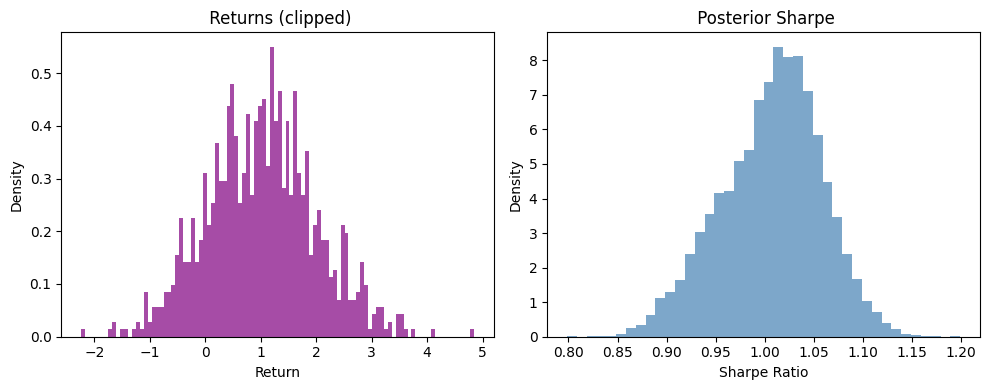

Return Distribution: 
 Min: -2.2412673400690726, Q1: 0.35240969453764837, Median: 1.0253006122348882, Q3: 1.64794387547293, Max: 4.852731490654721
Posterior mean Sharpe ratio: 1.0069185812882748
95% credible interval: [0.89810765 1.09964239]


In [32]:
    returns_normal = generate_normal_rets(n=1000)
    sharpe_normal = gibbs_sharpe(returns_normal)
    plot_returns_and_sharpe(returns_normal, sharpe_normal)
    summarize_returns(returns_normal)
    summarize_sharpe(sharpe_normal)

### STUDENT RETURNS

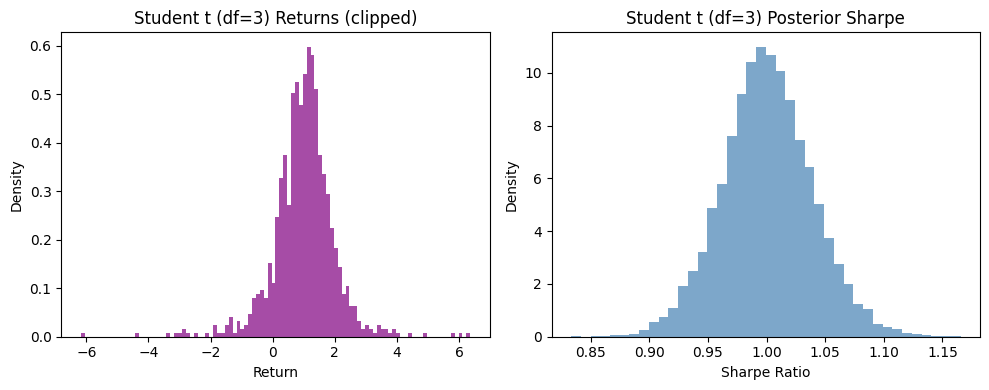

Return Distribution: 
 Min: -6.180581159475698, Q1: 0.5380097775846888, Median: 1.0268656210931253, Q3: 1.4996875779289343, Max: 6.357219713266264
Posterior mean Sharpe ratio: 1.0006705058793528
95% credible interval: [0.92508872 1.07831648]


In [33]:
    returns_student = generate_student_rets(n=1000, df=3)
    sharpe_student = gibbs_sharpe(returns_student)
    plot_returns_and_sharpe(returns_student, sharpe_student, name="Student t (df=3)")
    summarize_returns(returns_student)
    summarize_sharpe(sharpe_student)

### CAUCHY RETURNS

NB This is a degenrate example (mean is undefined)

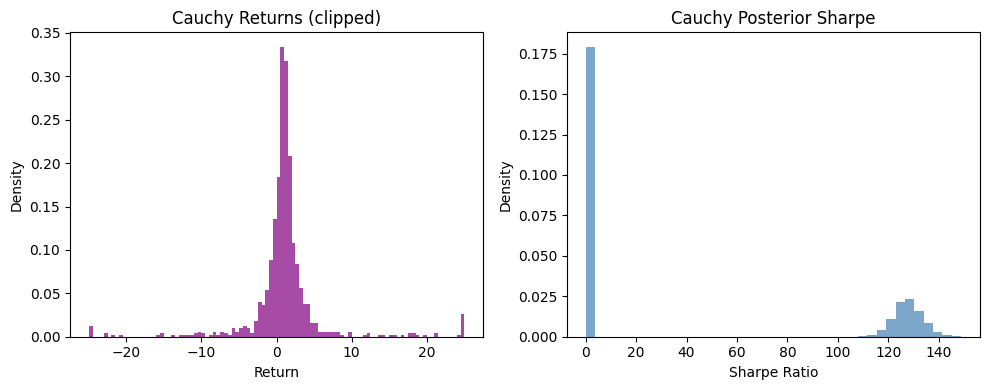

Return Distribution: 
 Min: -55.71641652928815, Q1: 0.012082668092152804, Median: 0.9808908718842582, Q3: 1.8526798218260254, Max: 243.46827972010615
Posterior mean Sharpe ratio: 43.22220912202196
95% credible interval: [9.93537831e-02 1.36391352e+02]


In [34]:
    returns_cauchy = generate_cauchy_rets(n=1000)
    sharpe_cauchy = gibbs_sharpe(returns_cauchy)
    plot_returns_and_sharpe(returns_cauchy, sharpe_cauchy, name="Cauchy")
    summarize_returns(returns_cauchy)
    summarize_sharpe(sharpe_cauchy)


